In [9]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [10]:
df = pd.read_csv(r"c:\Users\Lenovo\Downloads\CreditRisk Modeling Data.csv", sep=";")
df.columns


Index(['LOAN_AGREEMENT_NO', 'APPLICATION_DATE', 'APPLICATION_ID',
       'loan_amount', 'loan_tenure_in_months', 'PURPOSE_OF_LOAN',
       'LOAN_PRODUCT', 'LOAN_PRODUCT_LABEL', 'EXISTING_LOAN', 'LTV',
       'Credit_Amount', 'Branch', 'STATE', 'Charge description',
       'Charge Category', 'EMI', 'Total Times Paid', 'Status', 'grade'],
      dtype='object')

In [11]:
# If you need to parse dates in a specific column:
df['APPLICATION_DATE'] = pd.to_datetime(df['APPLICATION_DATE'], errors='coerce')

# Check basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21245 entries, 0 to 21244
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   LOAN_AGREEMENT_NO      21245 non-null  object        
 1   APPLICATION_DATE       5924 non-null   datetime64[ns]
 2   APPLICATION_ID         21245 non-null  int64         
 3   loan_amount            21245 non-null  int64         
 4   loan_tenure_in_months  21245 non-null  int64         
 5   PURPOSE_OF_LOAN        21245 non-null  object        
 6   LOAN_PRODUCT           21245 non-null  object        
 7   LOAN_PRODUCT_LABEL     21245 non-null  object        
 8   EXISTING_LOAN          21245 non-null  int64         
 9   LTV                    21245 non-null  int64         
 10  Credit_Amount          21245 non-null  float64       
 11  Branch                 21245 non-null  object        
 12  STATE                  21245 non-null  object        
 13  C

In [12]:
# Date boundaries
train_end = pd.to_datetime('2022-10-31')
nov_start = pd.to_datetime('2022-11-01')
nov_end = pd.to_datetime('2022-11-30')
dec_start = pd.to_datetime('2022-12-01')
dec_end = pd.to_datetime('2022-12-31')

# Split out datasets
train_test_df = df[df['APPLICATION_DATE'] <= train_end]
oot_nov = df[(df['APPLICATION_DATE'] >= nov_start) & (df['APPLICATION_DATE'] <= nov_end)]
oot_dec = df[(df['APPLICATION_DATE'] >= dec_start) & (df['APPLICATION_DATE'] <= dec_end)]


In [13]:
print('In-time (training/testing):', train_test_df.shape)
print('OOT NOV:', oot_nov.shape)
print('OOT DEC:', oot_dec.shape)

In-time (training/testing): (5924, 19)
OOT NOV: (0, 19)
OOT DEC: (0, 19)


Missing Value Treatment

In [14]:
# Simple median imputation for numerics and mode for categoricals
import numpy as np

# Identify numerical and categorical columns, excluding ID/date/target columns
exclude_cols = ['LOAN_AGREEMENT_NO', 'APPLICATION_DATE', 'APPLICATION_ID', 'Status']
num_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols)

# Impute numerics with median
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Impute categoricals with mode
for col in cat_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)


Outlier Treatment (Winsorization)

In [15]:
# Winsorize numeric columns at 1st and 99th percentile
for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)

In [16]:
# Choosing feature columns—exclude identifiers, date columns, and the target
#feature_cols = [col for col in df.columns if col not in ['APPLICATION_DATE', 'Status', 'LOAN_AGREEMENT_NO', 'APPLICATION_ID']]
feature_cols = [
    'loan_amount',
    'loan_tenure_in_months',
    'PURPOSE_OF_LOAN',
    'LOAN_PRODUCT',
    'LOAN_PRODUCT_LABEL',
    'EXISTING_LOAN',
    'LTV',
    'Credit_Amount',
    'Branch',
    'STATE'
]

# Split into X, y
X_train = train_test_df[feature_cols]
y_train = train_test_df['Status']

X_oot_nov = oot_nov[feature_cols]
y_oot_nov = oot_nov['Status']

X_oot_dec = oot_dec[feature_cols]
y_oot_dec = oot_dec['Status']


In [17]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)


Logistic Regression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split code, assuming df is loaded and APPLICATION_DATE is a datetime column:
train_end = pd.to_datetime('2022-10-31')
nov_start = pd.to_datetime('2022-11-01')
nov_end = pd.to_datetime('2022-11-30')
dec_start = pd.to_datetime('2022-12-01')
dec_end = pd.to_datetime('2022-12-31')

train_test_df = df[df['APPLICATION_DATE'] <= train_end]
oot_nov = df[(df['APPLICATION_DATE'] >= nov_start) & (df['APPLICATION_DATE'] <= nov_end)]
oot_dec = df[(df['APPLICATION_DATE'] >= dec_start) & (df['APPLICATION_DATE'] <= dec_end)]

#feature_cols = [col for col in df.columns if col not in ['APPLICATION_DATE', 'Status', 'LOAN_AGREEMENT_NO', 'APPLICATION_ID']]
feature_cols = [
    'loan_amount',
    'loan_tenure_in_months',
    'PURPOSE_OF_LOAN',
    'LOAN_PRODUCT',
    'LOAN_PRODUCT_LABEL',
    'EXISTING_LOAN',
    'LTV',
    'Credit_Amount',
    'Branch',
    'STATE'
]

X_train = train_test_df[feature_cols]
y_train = train_test_df['Status']

X_oot_nov = oot_nov[feature_cols]
y_oot_nov = oot_nov['Status']
X_oot_dec = oot_dec[feature_cols]
y_oot_dec = oot_dec['Status']

X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# --- One-hot Encoding ---
all_X = pd.concat([X_tr, X_te, X_oot_nov, X_oot_dec], axis=0)
cat_cols = all_X.select_dtypes(include=['object', 'category']).columns.tolist()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(all_X[cat_cols])

def ohe_transform_split(split_X):
    encoded = ohe.transform(split_X[cat_cols])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=split_X.index)
    non_cat = split_X.drop(columns=cat_cols)
    return pd.concat([non_cat, encoded_df], axis=1)

X_tr_enc = ohe_transform_split(X_tr)
X_te_enc = ohe_transform_split(X_te)

# Fit Logistic Regression
logreg = LogisticRegression(max_iter=500, solver='liblinear')
logreg.fit(X_tr_enc, y_tr)

X_oot_nov_enc = ohe_transform_split(X_oot_nov) if len(X_oot_nov) > 0 else None
X_oot_dec_enc = ohe_transform_split(X_oot_dec) if len(X_oot_dec) > 0 else None

# Fit Logistic Regression
logreg = LogisticRegression(max_iter=500, solver='liblinear')
logreg.fit(X_tr_enc, y_tr)


pred_train = logreg.predict(X_tr_enc)
pred_test = logreg.predict(X_te_enc)
pred_oot_nov = logreg.predict(X_oot_nov_enc) if X_oot_nov_enc is not None else None
pred_oot_dec = logreg.predict(X_oot_dec_enc) if X_oot_dec_enc is not None else None

acc_train = accuracy_score(y_tr, pred_train)
acc_test = accuracy_score(y_te, pred_test)
acc_oot_nov = accuracy_score(y_oot_nov, pred_oot_nov) if pred_oot_nov is not None and len(y_oot_nov) > 0 else None
acc_oot_dec = accuracy_score(y_oot_dec, pred_oot_dec) if pred_oot_dec is not None and len(y_oot_dec) > 0 else None

print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test Accuracy: {acc_test:.4f}")
print(f"OOT Nov 22 Accuracy: {acc_oot_nov}")
print(f"OOT Dec 22 Accuracy: {acc_oot_dec}\n")
print('Classification Report (Test):\n', classification_report(y_te, pred_test))

from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss, precision_score

# y_te: true labels, pred_test: predicted labels, prob_test: predicted probabilities for class 1
X_te_enc_aligned = X_te_enc.reindex(columns=X_tr_enc.columns, fill_value=0)
prob_test = logreg.predict_proba(X_te_enc_aligned)[:, 1]

# F1 Score
f1 = f1_score(y_te, pred_test)
print(f"F1 Score: {f1:.4f}")

# Recall (same as TPR/sensitivity for class 1)
recall = recall_score(y_te, pred_test)
print(f"Recall (TPR): {recall:.4f}")

# Confusion matrix for TPR, FPR
tn, fp, fn, tp = confusion_matrix(y_te, pred_test).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.4f}")

# AUC
auc = roc_auc_score(y_te, prob_test)
print(f"AUC: {auc:.4f}")

# GINI coefficient
gini = 2 * auc - 1
print(f"GINI: {gini:.4f}")

# KS statistic
fpr_vals, tpr_vals, thresholds = roc_curve(y_te, prob_test)
ks = max(tpr_vals - fpr_vals)
print(f"KS: {ks:.4f}")

# Brier Score
brier = brier_score_loss(y_te, prob_test)
print(f"Brier Score: {brier:.4f}")



Train Accuracy: 0.6185
Test Accuracy: 0.6135
OOT Nov 22 Accuracy: None
OOT Dec 22 Accuracy: None

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.60      0.90      0.72       665
           1       0.66      0.24      0.36       520

    accuracy                           0.61      1185
   macro avg       0.63      0.57      0.54      1185
weighted avg       0.63      0.61      0.56      1185

F1 Score: 0.3567
Recall (TPR): 0.2442
TPR: 0.2442
FPR: 0.0977
AUC: 0.5207
GINI: 0.0415
KS: 0.1472
Brier Score: 0.2402


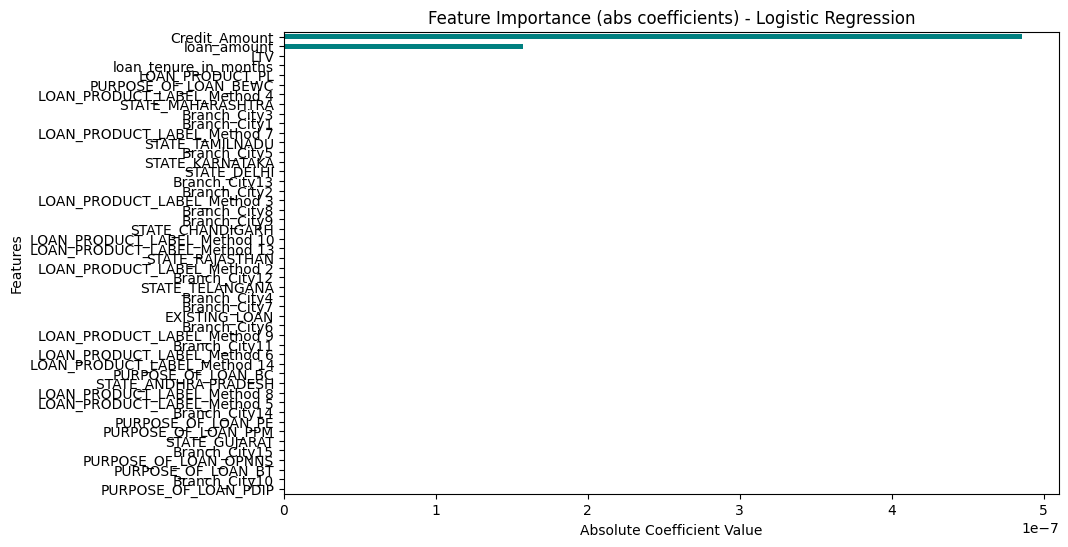

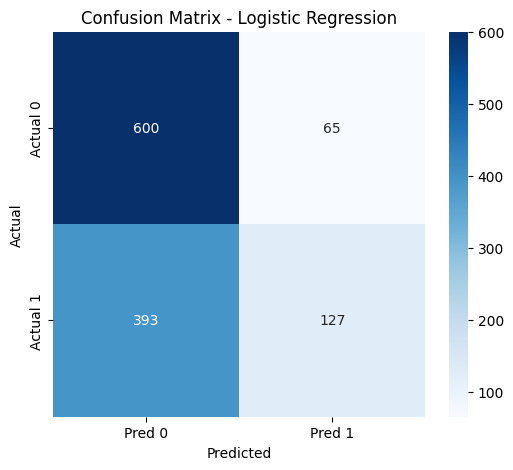

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

# Feature importance for logistic regression
coefs = pd.Series(np.abs(logreg.coef_[0]), index=X_tr_enc.columns)
coefs_sorted = coefs.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
coefs_sorted.plot(kind='barh', color='teal')
plt.title('Feature Importance (abs coefficients) - Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.show()


# Confusion Matrix
# Predict classes on test set
pred_test = logreg.predict(X_te_enc_aligned)

cm = confusion_matrix(y_te, pred_test)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Random Forest

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Feature columns that do not leak target info
feature_cols = [
    'loan_amount',
    'loan_tenure_in_months',
    'PURPOSE_OF_LOAN',
    'LOAN_PRODUCT',
    'LOAN_PRODUCT_LABEL',
    'EXISTING_LOAN',
    'LTV',
    'Credit_Amount',
    'Branch',
    'STATE'
]

# Data splits as before
X_train = train_test_df[feature_cols]
y_train = train_test_df['Status']

X_oot_nov = oot_nov[feature_cols]
y_oot_nov = oot_nov['Status']
X_oot_dec = oot_dec[feature_cols]
y_oot_dec = oot_dec['Status']

X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# --- One-hot Encoding ---
all_X = pd.concat([X_tr, X_te, X_oot_nov, X_oot_dec], axis=0)
cat_cols = all_X.select_dtypes(include=['object', 'category']).columns.tolist()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(all_X[cat_cols])

def ohe_transform_split(split_X):
    if len(split_X) == 0:
        return None
    encoded = ohe.transform(split_X[cat_cols])
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cat_cols), index=split_X.index)
    non_cat = split_X.drop(columns=cat_cols)
    return pd.concat([non_cat, encoded_df], axis=1)

X_tr_enc = ohe_transform_split(X_tr)
X_te_enc = ohe_transform_split(X_te)

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr_enc, y_tr)

X_oot_nov_enc = ohe_transform_split(X_oot_nov)
X_oot_dec_enc = ohe_transform_split(X_oot_dec)

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr_enc, y_tr)

pred_train_rf = rf.predict(X_tr_enc)
pred_test_rf = rf.predict(X_te_enc)
pred_oot_nov_rf = rf.predict(X_oot_nov_enc) if X_oot_nov_enc is not None else None
pred_oot_dec_rf = rf.predict(X_oot_dec_enc) if X_oot_dec_enc is not None else None

acc_train_rf = accuracy_score(y_tr, pred_train_rf)
acc_test_rf = accuracy_score(y_te, pred_test_rf)
acc_oot_nov_rf = accuracy_score(y_oot_nov, pred_oot_nov_rf) if pred_oot_nov_rf is not None and len(y_oot_nov) > 0 else None
acc_oot_dec_rf = accuracy_score(y_oot_dec, pred_oot_dec_rf) if pred_oot_dec_rf is not None and len(y_oot_dec) > 0 else None

print(f"RF Train Accuracy: {acc_train_rf:.4f}")
print(f"RF Test Accuracy: {acc_test_rf:.4f}")
print(f"RF OOT Nov 22 Accuracy: {acc_oot_nov_rf}")
print(f"RF OOT Dec 22 Accuracy: {acc_oot_dec_rf}\n")
print('Classification Report (Test):\n', classification_report(y_te, pred_test_rf))

from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss

# Probabilities for class 1 (default)
prob_test_rf = rf.predict_proba(X_te_enc)[:, 1]

# F1 Score
f1_rf = f1_score(y_te, pred_test_rf)
print(f"F1 Score: {f1_rf:.4f}")

# Recall / TPR (Sensitivity)
recall_rf = recall_score(y_te, pred_test_rf)
print(f"Recall (TPR): {recall_rf:.4f}")

# Confusion matrix for TPR, FPR
tn, fp, fn, tp = confusion_matrix(y_te, pred_test_rf).ravel()
tpr_rf = tp / (tp + fn)
fpr_rf = fp / (fp + tn)
print(f"TPR: {tpr_rf:.4f}")
print(f"FPR: {fpr_rf:.4f}")

# AUC
auc_rf = roc_auc_score(y_te, prob_test_rf)
print(f"AUC: {auc_rf:.4f}")

# GINI coefficient
gini_rf = 2 * auc_rf - 1
print(f"GINI: {gini_rf:.4f}")

# KS statistic
fpr_vals_rf, tpr_vals_rf, thresholds_rf = roc_curve(y_te, prob_test_rf)
ks_rf = max(tpr_vals_rf - fpr_vals_rf)
print(f"KS: {ks_rf:.4f}")

# Brier Score
brier_rf = brier_score_loss(y_te, prob_test_rf)
print(f"Brier Score: {brier_rf:.4f}")

RF Train Accuracy: 0.9911
RF Test Accuracy: 0.9046
RF OOT Nov 22 Accuracy: None
RF OOT Dec 22 Accuracy: None

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       665
           1       0.89      0.90      0.89       520

    accuracy                           0.90      1185
   macro avg       0.90      0.90      0.90      1185
weighted avg       0.90      0.90      0.90      1185

F1 Score: 0.8919
Recall (TPR): 0.8962
TPR: 0.8962
FPR: 0.0887
AUC: 0.9559
GINI: 0.9118
KS: 0.8087
Brier Score: 0.0807


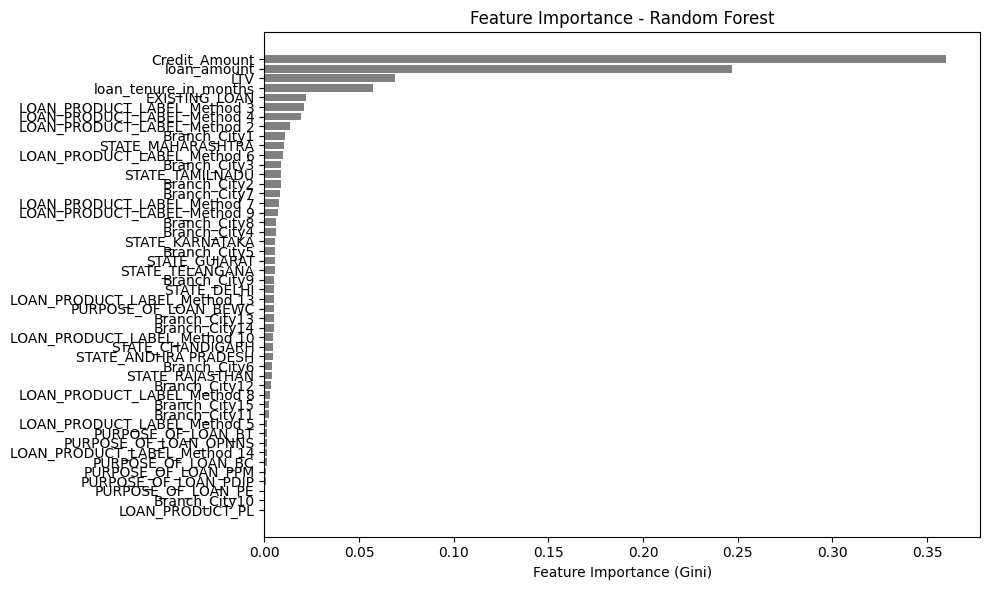

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Feature importance for Random Forest
importances_rf = rf.feature_importances_
features_rf = X_tr_enc.columns
# Sort features by importance (ascending)
indices_rf = importances_rf.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features_rf[indices_rf], importances_rf[indices_rf], color='grey')
plt.xlabel('Feature Importance (Gini)')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

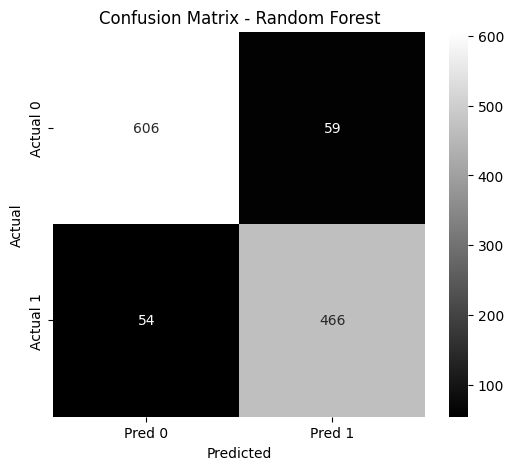

In [22]:
# Predict classes on test set
pred_test_rf = rf.predict(X_te_enc_aligned)

cm_rf = confusion_matrix(y_te, pred_test_rf)
cm_rf_df = pd.DataFrame(cm_rf, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_df, annot=True, fmt='d', cmap="grey")
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

GradientBoost

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_tr_enc, y_tr)

pred_train_gb = gb.predict(X_tr_enc)
pred_test_gb = gb.predict(X_te_enc)
pred_oot_nov_gb = gb.predict(X_oot_nov_enc) if X_oot_nov_enc is not None else None
pred_oot_dec_gb = gb.predict(X_oot_dec_enc) if X_oot_dec_enc is not None else None

acc_train_gb = accuracy_score(y_tr, pred_train_gb)
acc_test_gb = accuracy_score(y_te, pred_test_gb)
acc_oot_nov_gb = accuracy_score(y_oot_nov, pred_oot_nov_gb) if pred_oot_nov_gb is not None and len(y_oot_nov) > 0 else None
acc_oot_dec_gb = accuracy_score(y_oot_dec, pred_oot_dec_gb) if pred_oot_dec_gb is not None and len(y_oot_dec) > 0 else None

print(f"GB Train Accuracy: {acc_train_gb:.4f}")
print(f"GB Test Accuracy: {acc_test_gb:.4f}")
print(f"GB OOT Nov 22 Accuracy: {acc_oot_nov_gb}")
print(f"GB OOT Dec 22 Accuracy: {acc_oot_dec_gb}\n")
print('Classification Report (Test):\n', classification_report(y_te, pred_test_gb))

from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss

# Probabilities for class 1 (default)
prob_test_rf = rf.predict_proba(X_te_enc)[:, 1]

# F1 Score
f1_rf = f1_score(y_te, pred_test_rf)
print(f"F1 Score: {f1_rf:.4f}")

# Recall / TPR (Sensitivity)
recall_rf = recall_score(y_te, pred_test_rf)
print(f"Recall (TPR): {recall_rf:.4f}")

# Confusion matrix for TPR, FPR
tn, fp, fn, tp = confusion_matrix(y_te, pred_test_rf).ravel()
tpr_rf = tp / (tp + fn)
fpr_rf = fp / (fp + tn)
print(f"TPR: {tpr_rf:.4f}")
print(f"FPR: {fpr_rf:.4f}")

# AUC
auc_rf = roc_auc_score(y_te, prob_test_rf)
print(f"AUC: {auc_rf:.4f}")

# GINI coefficient
gini_rf = 2 * auc_rf - 1
print(f"GINI: {gini_rf:.4f}")

# KS statistic
fpr_vals_rf, tpr_vals_rf, thresholds_rf = roc_curve(y_te, prob_test_rf)
ks_rf = max(tpr_vals_rf - fpr_vals_rf)
print(f"KS: {ks_rf:.4f}")

# Brier Score
brier_rf = brier_score_loss(y_te, prob_test_rf)
print(f"Brier Score: {brier_rf:.4f}")


GB Train Accuracy: 0.7548
GB Test Accuracy: 0.7215
GB OOT Nov 22 Accuracy: None
GB OOT Dec 22 Accuracy: None

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.73      0.79      0.76       665
           1       0.70      0.63      0.67       520

    accuracy                           0.72      1185
   macro avg       0.72      0.71      0.71      1185
weighted avg       0.72      0.72      0.72      1185

F1 Score: 0.8919
Recall (TPR): 0.8962
TPR: 0.8962
FPR: 0.0887
AUC: 0.9559
GINI: 0.9118
KS: 0.8087
Brier Score: 0.0807


Tuning the current GBM model

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)

# Grid search with 3-fold cross-validation, scoring by accuracy
grid = GridSearchCV(gb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_tr_enc, y_tr)

print("Best parameters:", grid.best_params_)
print(f"Best CV score: {grid.best_score_:.4f}")

# Use best model for test set and report
best_gb = grid.best_estimator_
pred_test_gb = best_gb.predict(X_te_enc)

print(f"Tuned GB Test Accuracy: {accuracy_score(y_te, pred_test_gb):.4f}")
print("Tuned GB Classification Report (Test):")
print(classification_report(y_te, pred_test_gb))

from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss

# Probabilities for test set (class 1)
prob_test_gb = best_gb.predict_proba(X_te_enc)[:, 1]
pred_test_gb = best_gb.predict(X_te_enc)

# F1 Score
f1_gb = f1_score(y_te, pred_test_gb)
print(f"F1 Score: {f1_gb:.4f}")

# Recall / TPR (Sensitivity)
recall_gb = recall_score(y_te, pred_test_gb)
print(f"Recall (TPR): {recall_gb:.4f}")

# Confusion matrix for TPR, FPR
tn, fp, fn, tp = confusion_matrix(y_te, pred_test_gb).ravel()
tpr_gb = tp / (tp + fn)
fpr_gb = fp / (fp + tn)
print(f"TPR: {tpr_gb:.4f}")
print(f"FPR: {fpr_gb:.4f}")

# AUC
auc_gb = roc_auc_score(y_te, prob_test_gb)
print(f"AUC: {auc_gb:.4f}")

# GINI
gini_gb = 2 * auc_gb - 1
print(f"GINI: {gini_gb:.4f}")

# KS statistic
fpr_vals_gb, tpr_vals_gb, thresholds_gb = roc_curve(y_te, prob_test_gb)
ks_gb = max(tpr_vals_gb - fpr_vals_gb)
print(f"KS: {ks_gb:.4f}")

# Brier Score
brier_gb = brier_score_loss(y_te, prob_test_gb)
print(f"Brier Score: {brier_gb:.4f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best CV score: 0.8945
Tuned GB Test Accuracy: 0.9274
Tuned GB Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       665
           1       0.92      0.91      0.92       520

    accuracy                           0.93      1185
   macro avg       0.93      0.93      0.93      1185
weighted avg       0.93      0.93      0.93      1185

F1 Score: 0.9167
Recall (TPR): 0.9096
TPR: 0.9096
FPR: 0.0586
AUC: 0.9750
GINI: 0.9499
KS: 0.8555
Brier Score: 0.0581


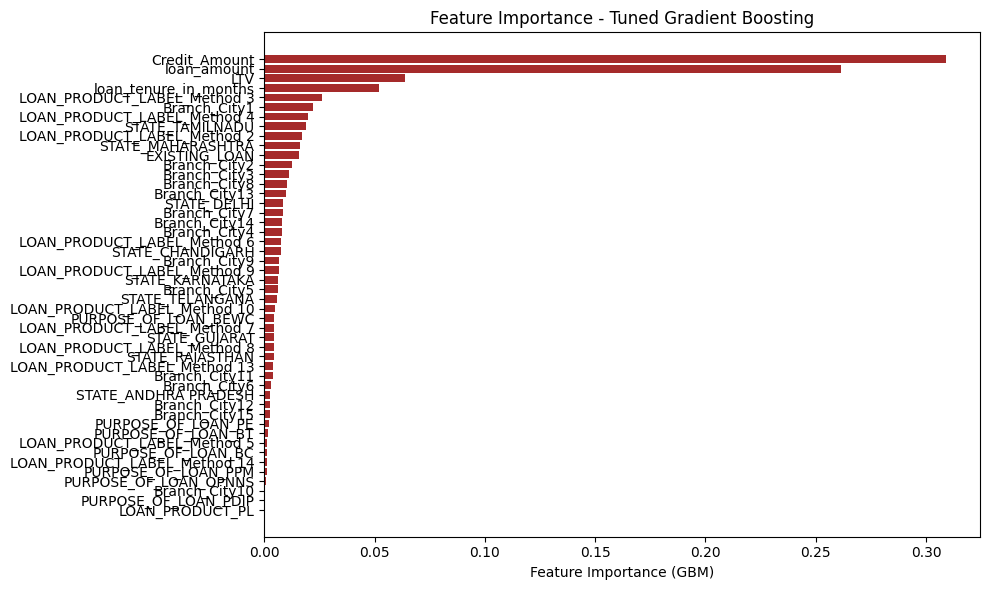

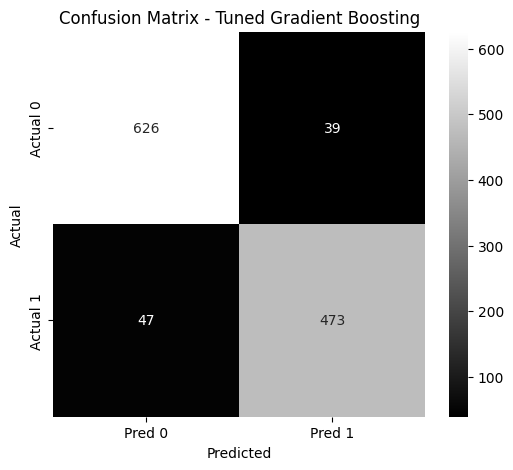

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Feature Importance for tuned Gradient Boosting (best_gb)
importances_gb = best_gb.feature_importances_
features_gb = X_tr_enc.columns
indices_gb = importances_gb.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features_gb[indices_gb], importances_gb[indices_gb], color='brown')
plt.xlabel('Feature Importance (GBM)')
plt.title('Feature Importance - Tuned Gradient Boosting')
plt.tight_layout()
plt.show()

# Confusion Matrix
pred_test_gb = best_gb.predict(X_te_enc_aligned)
cm_gb = confusion_matrix(y_te, pred_test_gb)
cm_gb_df = pd.DataFrame(cm_gb, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_gb_df, annot=True, fmt='d', cmap='grey')
plt.title('Confusion Matrix - Tuned Gradient Boosting')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

XGBoost

In [ ]:
#!pip install xgboost

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss, classification_report

# --- XGBoost ---
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=1.0,
    use_label_encoder=False,  # For newer versions
    eval_metric='logloss',    # To suppress warnings
    random_state=42
)
xgb.fit(X_tr_enc, y_tr)

pred_train_xgb = xgb.predict(X_tr_enc)
pred_test_xgb = xgb.predict(X_te_enc)

print(f"XGB Train Accuracy: {accuracy_score(y_tr, pred_train_xgb):.4f}")
print(f"XGB Test Accuracy: {accuracy_score(y_te, pred_test_xgb):.4f}")

print("XGB Classification Report (Test):\n", classification_report(y_te, pred_test_xgb))

# Probabilities for class 1 (default)
prob_test_xgb = xgb.predict_proba(X_te_enc)[:, 1]

# Advanced metrics
f1_xgb = f1_score(y_te, pred_test_xgb)
acc_test_xgb = accuracy_score(y_te, pred_test_xgb)
recall_xgb = recall_score(y_te, pred_test_xgb)
tn, fp, fn, tp = confusion_matrix(y_te, pred_test_xgb).ravel()
tpr_xgb = tp / (tp + fn)
fpr_xgb = fp / (fp + tn)
auc_xgb = roc_auc_score(y_te, prob_test_xgb)
gini_xgb = 2 * auc_xgb - 1
fpr_vals_xgb, tpr_vals_xgb, thresholds = roc_curve(y_te, prob_test_xgb)
ks_xgb = max(tpr_vals_xgb - fpr_vals_xgb)
brier_xgb = brier_score_loss(y_te, prob_test_xgb)

print(f"F1 Score: {f1_xgb:.4f}")
print(f"Recall (TPR): {recall_xgb:.4f}")
print(f"TPR: {tpr_xgb:.4f}")
print(f"FPR: {fpr_xgb:.4f}")
print(f"AUC: {auc_xgb:.4f}")
print(f"GINI: {gini_xgb:.4f}")
print(f"KS: {ks_xgb:.4f}")
print(f"Brier Score: {brier_xgb:.4f}")


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:30:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB Train Accuracy: 0.9390
XGB Test Accuracy: 0.8734
XGB Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       665
           1       0.88      0.83      0.85       520

    accuracy                           0.87      1185
   macro avg       0.87      0.87      0.87      1185
weighted avg       0.87      0.87      0.87      1185

F1 Score: 0.8515
Recall (TPR): 0.8269
TPR: 0.8269
FPR: 0.0902
AUC: 0.9447
GINI: 0.8895
KS: 0.7623
Brier Score: 0.0962


XGBoost Tuning

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Grid search with 3-fold cross-validation
grid_xgb = GridSearchCV(
    xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_xgb.fit(X_tr_enc, y_tr)

# Report best parameters and score
print("Best parameters:", grid_xgb.best_params_)
print(f"Best CV score: {grid_xgb.best_score_:.4f}")

# Use the best model to predict/test/report
best_xgb = grid_xgb.best_estimator_
pred_test_xgb = best_xgb.predict(X_te_enc)
prob_test_xgb = best_xgb.predict_proba(X_te_enc)[:, 1]

print(f"Tuned XGB Test Accuracy: {accuracy_score(y_te, pred_test_xgb):.4f}")
print("Tuned XGB Classification Report (Test):\n", classification_report(y_te, pred_test_xgb))

# Advanced metrics
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, brier_score_loss

f1_xgb = f1_score(y_te, pred_test_xgb)
acc_test_xgb = accuracy_score(y_te, pred_test_xgb)
recall_xgb = recall_score(y_te, pred_test_xgb)
tn, fp, fn, tp = confusion_matrix(y_te, pred_test_xgb).ravel()
tpr_xgb = tp / (tp + fn)
fpr_xgb = fp / (fp + tn)
auc_xgb = roc_auc_score(y_te, prob_test_xgb)
gini_xgb = 2 * auc_xgb - 1
fpr_vals_xgb, tpr_vals_xgb, thresholds = roc_curve(y_te, prob_test_xgb)
ks_xgb = max(tpr_vals_xgb - fpr_vals_xgb)
brier_xgb = brier_score_loss(y_te, prob_test_xgb)

print(f"F1 Score: {f1_xgb:.4f}")
print(f"Recall (TPR): {recall_xgb:.4f}")
print(f"TPR: {tpr_xgb:.4f}")
print(f"FPR: {fpr_xgb:.4f}")
print(f"AUC: {auc_xgb:.4f}")
print(f"GINI: {gini_xgb:.4f}")
print(f"KS: {ks_xgb:.4f}")
print(f"Brier Score: {brier_xgb:.4f}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:31:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best CV score: 0.8747
Tuned XGB Test Accuracy: 0.8869
Tuned XGB Classification Report (Test):
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       665
           1       0.88      0.86      0.87       520

    accuracy                           0.89      1185
   macro avg       0.89      0.88      0.88      1185
weighted avg       0.89      0.89      0.89      1185

F1 Score: 0.8696
Recall (TPR): 0.8596
TPR: 0.8596
FPR: 0.0917
AUC: 0.9579
GINI: 0.9157
KS: 0.7834
Brier Score: 0.0799


<Figure size 1000x600 with 0 Axes>

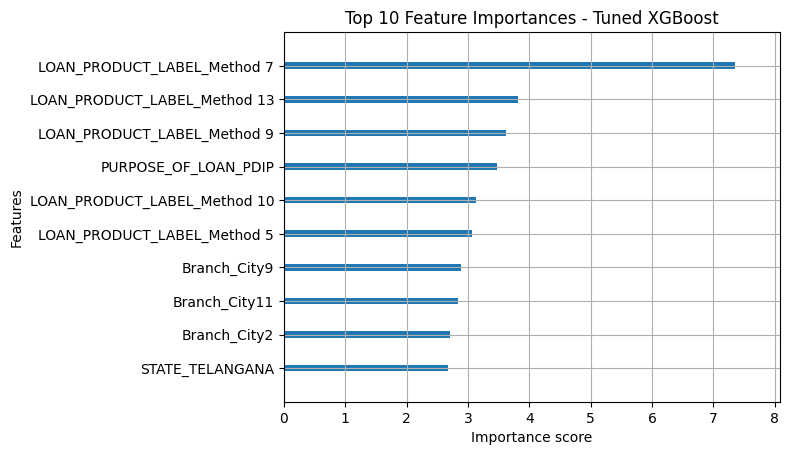

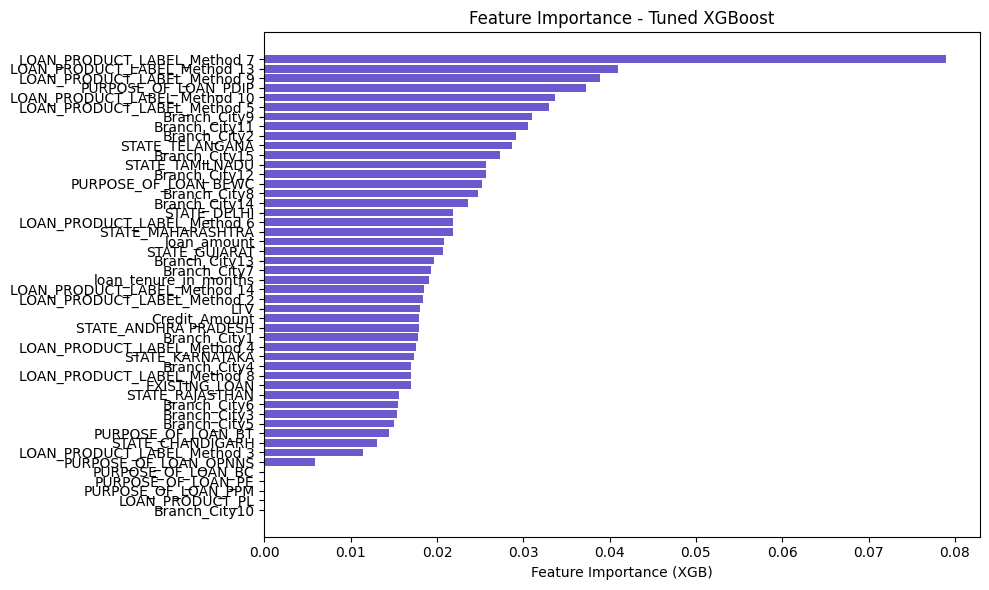

In [27]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Feature Importance Plot (built-in, top 10 features by gain)
plt.figure(figsize=(10, 6))
plot_importance(best_xgb, max_num_features=10, importance_type='gain', show_values=False)
plt.title('Top 10 Feature Importances - Tuned XGBoost')
plt.show()

# --- Optional: If you want to plot all features, or use a custom barh plot: ---
importances_xgb = best_xgb.feature_importances_
features_xgb = X_tr_enc.columns
indices_xgb = importances_xgb.argsort()

plt.figure(figsize=(10, 6))
plt.barh(features_xgb[indices_xgb], importances_xgb[indices_xgb], color='slateblue')
plt.xlabel('Feature Importance (XGB)')
plt.title('Feature Importance - Tuned XGBoost')
plt.tight_layout()
plt.show()


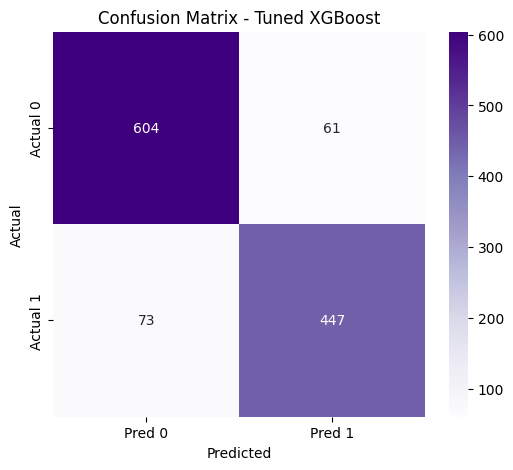

In [28]:
# Predictions (if not already defined)
pred_test_xgb = best_xgb.predict(X_te_enc_aligned)

cm_xgb = confusion_matrix(y_te, pred_test_xgb)
cm_xgb_df = pd.DataFrame(cm_xgb, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb_df, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - Tuned XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

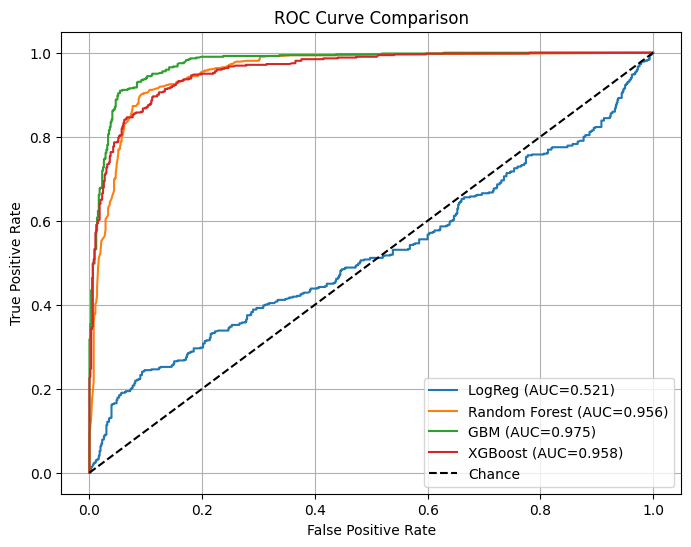

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
X_te_enc_aligned = X_te_enc.reindex(columns=X_tr_enc.columns, fill_value=0).astype(float)

plt.figure(figsize=(8, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_te, logreg.predict_proba(X_te_enc_aligned)[:, 1])
auc_lr = roc_auc_score(y_te, logreg.predict_proba(X_te_enc_aligned)[:, 1])
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.3f})')

fpr_rf, tpr_rf, _ = roc_curve(y_te, rf.predict_proba(X_te_enc_aligned)[:, 1])
auc_rf = roc_auc_score(y_te, rf.predict_proba(X_te_enc_aligned)[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')

fpr_gb, tpr_gb, _ = roc_curve(y_te, best_gb.predict_proba(X_te_enc_aligned)[:, 1])
auc_gb = roc_auc_score(y_te, best_gb.predict_proba(X_te_enc_aligned)[:, 1])
plt.plot(fpr_gb, tpr_gb, label=f'GBM (AUC={auc_gb:.3f})')

fpr_xgb, tpr_xgb, _ = roc_curve(y_te, best_xgb.predict_proba(X_te_enc_aligned)[:, 1])
auc_xgb = roc_auc_score(y_te, best_xgb.predict_proba(X_te_enc_aligned)[:, 1])
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')

plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [30]:
results = pd.DataFrame({
    'Model': ['Logistic', 'RF', 'GBM', 'XGBoost'],
    'AUC': [auc_lr, auc_rf, auc_gb, auc_xgb],
    'KS': [ks, ks_rf, ks_gb, ks_xgb],
    'Accuracy': [acc_test, acc_test_rf, acc_test_gb, acc_test_xgb],
    'Recall': [recall, recall_rf, recall_gb, recall_xgb],
    'GINI': [gini, gini_rf, gini_gb, gini_xgb],
    'Brier': [brier, brier_rf, brier_gb, brier_xgb]
})
print(results)


      Model       AUC        KS  Accuracy    Recall      GINI     Brier
0  Logistic  0.520739  0.147152  0.613502  0.244231  0.041478  0.240220
1        RF  0.955886  0.808690  0.904641  0.896154  0.911773  0.080708
2       GBM  0.974970  0.855480  0.721519  0.909615  0.949939  0.058082
3   XGBoost  0.957861  0.783372  0.886920  0.859615  0.915723  0.079870


LIFT TABLE

In [31]:
import pandas as pd
import numpy as np

def lift_table_full(y_true, y_score, n_bins=10):
    df = pd.DataFrame({'actual': y_true, 'score': y_score})
    df = df.sort_values('score', ascending=False).reset_index(drop=True)
    # Use duplicates='drop' to avoid bin edge errors
    df['Decile'] = pd.qcut(df.index + 1, q=n_bins, labels=range(1, n_bins + 1), duplicates='drop')

    # Calculate responders/defaulters & non-responders per decile
    grouped = df.groupby('Decile')['actual'].agg([
        ('Responder/Defaulter', 'sum'),
        ('Non-Responder/Non-Defaulter', lambda x: (1-x).sum())
    ]).reset_index()

    # Cumulative sums
    grouped['Cumulative Defaulter'] = grouped['Responder/Defaulter'].cumsum()
    grouped['Cumulative Non-Defaulter'] = grouped['Non-Responder/Non-Defaulter'].cumsum()
    total_defaulters = grouped['Responder/Defaulter'].sum()
    total_nondefaulters = grouped['Non-Responder/Non-Defaulter'].sum()

    grouped['Cumulative Defaulter Rate'] = grouped['Cumulative Defaulter'] / total_defaulters
    grouped['Cumulative Non-Defaulter Rate'] = grouped['Cumulative Non-Defaulter'] / total_nondefaulters
    # Random: expected rate by decile
    grouped['Random'] = 1.0 / len(grouped)
    grouped['Cumulative Random'] = grouped['Random'].cumsum()
    # Lift: model cumulative capture divided by random cumulative
    grouped['Lift'] = grouped['Cumulative Defaulter Rate'] / grouped['Cumulative Random']
    # KS
    grouped['KS'] = (grouped['Cumulative Defaulter Rate'] - grouped['Cumulative Non-Defaulter Rate']).abs()

    return grouped[['Decile',
                    'Responder/Defaulter',
                    'Non-Responder/Non-Defaulter',
                    'Cumulative Defaulter',
                    'Cumulative Defaulter Rate',
                    'Cumulative Non-Defaulter Rate',
                    'Random',
                    'Cumulative Random',
                    'Lift',
                    'KS']]

# Example usage:
lift_df = lift_table_full(y_te, prob_test_xgb, n_bins=10)
print(lift_df)


  Decile  Responder/Defaulter  Non-Responder/Non-Defaulter  \
0      1                  118                            1   
1      2                  115                            3   
2      3                  108                           11   
3      4                   92                           26   
4      5                   52                           67   
5      6                   20                           98   
6      7                    9                          109   
7      8                    5                          114   
8      9                    1                          117   
9     10                    0                          119   

   Cumulative Defaulter  Cumulative Defaulter Rate  \
0                   118                   0.226923   
1                   233                   0.448077   
2                   341                   0.655769   
3                   433                   0.832692   
4                   485                   0.932

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11148\4237255840.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Decile')['actual'].agg([


In [32]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True) # Makes all DataFrames interactive
lift_df

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [1]:
!pip install itables

In [3]:
import sys
print(sys.executable)



c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\python.exe


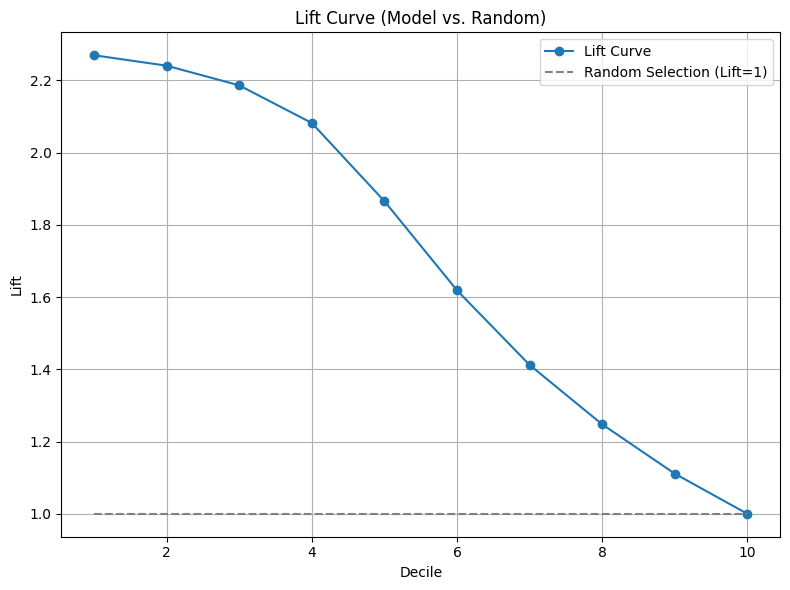

In [64]:
import matplotlib.pyplot as plt

# Example assumes lift_df is your lift table DataFrame
plt.figure(figsize=(8, 6))
plt.plot(lift_df['Decile'], lift_df['Lift'], marker='o', label='Lift Curve')
plt.plot(lift_df['Decile'], [1]*len(lift_df), linestyle='--', color='grey', label='Random Selection (Lift=1)')
plt.xlabel('Decile')
plt.ylabel('Lift')
plt.title('Lift Curve (Model vs. Random)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
